In [2]:
import random
import pandas as pd
import numpy as np
import csv
import copy
import re

print("Start of data adjust")
data = pd.read_csv('./Dataset/data.csv')
row_swaps = ['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'speechiness',
 'tempo',
 'valence',
 'year',
 'artists',
 'name',
 'release_date',
 'id']

# Here's how you reduce sample the data set.
# sample_data will contain every 100th row. This is just as an example
# Should use more than a 100th of the data
sample_data = data.iloc[::, :]
sample_data.head()
sample_data = sample_data[row_swaps]

# Splitting the data into features and song profiles
song_profiles = sample_data[['id', 'name', 'artists', 'release_date', 'year']].copy()
onlyartists = song_profiles.copy().filter('artists').values
features = (sample_data.copy()
    .drop('name', axis=1)
    .drop('id', axis=1)
    .drop('release_date', axis=1)
    .values.tolist())

def RemoveMultiArtistSongs(features):
    expr = re.compile("\'\,")
    output = []
    for row in features:
        artist_str = row[-1]
        if expr.match(artist_str) == None:
            output.append(row)
    return output

def GetOnly90sSongs(features):
    outfeatures = []
    for row in features:
        if row[-2] >= 1990.0 and row[-2] < 2000.0:
            outfeatures.append(row)
    return outfeatures

def GetOnly10ArtistsSongs(features):
    artists = set()
    out = []
    while len(artists) < 10:
        row = random.sample(features, 1)
        artists.add(row[0][-1])
    
    for row in features:
        if (row[-1] in artists):
            out.append(row)
    return out, artists

# def CalcClass(value, length):
#     output = [-1 for _ in range(length)]
    
#     i = 0
#     while(value > 0):
#         output[i] = 1 if (value % 2 == 1) else -1
#         value = value // 2
#         i += 1

#     return output

def CalcNormalizations(features):
    maxes = [0 for _ in range(len(features[0]))]
    mins = [30000 for _ in range (len(features[0]))]
    for row in features:
        for i in range(len(row) - 1):
            if (abs(row[i]) > maxes[i]):
                maxes[i] = abs(row[i])
            if (row[i] < mins[i]):
                mins[i] = row[i]
    
    ofeatures = copy.deepcopy(features)
    length = len(ofeatures[0])
    
    for i in range(len(maxes)):
        maxes[i] -= mins[i]

    for row in ofeatures:
        for i in range(len(row) - 1):
            if (maxes[i] > 0):
                row[i] = (row[i] - mins[i])/maxes[0]

    return ofeatures

def GetNumClasses(ofeatures):
    classes = set()
    for row in ofeatures:
        classes.add(row[-1])
    return len(classes)

print("Removing songs with multiple artists...")
noMultipleArtists = RemoveMultiArtistSongs(features)
# print("Getting all songs from the 90's...")
# _90ssongs = GetOnly90sSongs(features)
print("Retrieving only 10 artists")
# _10AristsSongs, Artists = GetOnly10ArtistsSongs(_90ssongs)
_10ArtistsSongs, Artists = GetOnly10ArtistsSongs(noMultipleArtists)
Artists = list(Artists)
# Artists = onlyartists
print("Normalizing the data...")
normalized_data_with_classes = CalcNormalizations(_10ArtistsSongs)
# num_classes = GetNumClasses(features)
print("Sorting into training and testing sets...")
train_features = random.sample(normalized_data_with_classes, len(normalized_data_with_classes)*2//3)
test_features = []
for row in normalized_data_with_classes:
    if row not in train_features:
        test_features.append(row)

print("Form data for tensorflow")
tf_train_features = []
tf_train_labels = []
tf_test_features = []
tf_test_labels = []

for row in train_features:
    tf_train_features.append(row[:-1])
    tf_train_labels.append(Artists.index(row[-1]))

for row in test_features:
    tf_test_features.append(row[:-1])
    tf_test_labels.append(Artists.index(row[-1]))
tf_dataset = (tf_train_features, tf_train_labels, tf_test_features, tf_test_labels)
print("Complete!")

Start of data adjust
Removing songs with multiple artists...
Retrieving only 10 artists
Normalizing the data...
Sorting into training and testing sets...
Form data for tensorflow
Complete!


In [3]:
%%html
<style>
div.output_area pre {
    white-space: pre;
}
</style>

In [4]:
import math
import random
import copy

debug = False
info_dump = False

class Neuron:
    Weights = []
    Output = 1.0
    Delta = 0.5
    
    def __init__(self, layerWidth):
        self.Weights = [random.random() for _ in range(layerWidth + 1)]
    
    def Activate(self, inputs):
        activation_val = self.Weights[-1]
        if (debug):
            print("\tsanity check:\n\t\t", inputs, len(inputs), "\n\t\t", self.Weights, len(self.Weights))
        for i in range(len(inputs)):
            activation_val += inputs[i] * self.Weights[i]
        self.Output = math.tanh(activation_val)
        if (debug):
            print("\toutput sanity check:", self.Output)
        return self.Output
    
    def UpdateWeights(self, regressive_outputs, learn_rate):
        if (debug):
            print("UpdateWeights sanity check\n", regressive_outputs)
            print("\tUpdateWeights Lengths:", len(self.Weights), len(regressive_outputs))
        for i in range(len(regressive_outputs)):
            self.Weights[i] += learn_rate * self.Delta * regressive_outputs[i]
        self.Weights[-1] += learn_rate * self.Delta
    
    def UpdateDelta(self, error):
        self.Delta = error * (1 - np.tanh(self.Output)**2)

class DenseNeuralNetwork:
    def __init__(self, features, hidden_layers, output_length, learning_rate):
        self.RecurrentInputs = 0
        self.OutputLength = 0
        self.NeuronLayers = []
        self.LearningRate = 0.0
        print("Building neural network with", features, "features, and", hidden_layers, "hidden layers.")
        self.LearningRate = learning_rate
        self.OutputLength = output_length
        
        y_intercept = features
        slope = (output_length - y_intercept)/hidden_layers
        num_weights = y_intercept
        
        for i in range(hidden_layers + 1):
            layer_len = math.ceil((i*slope + y_intercept)) if (i < hidden_layers) else output_length
            print("\tBuilding layer", i, "with", layer_len, "neurons.")
            new_layer = [Neuron(num_weights) for _ in range(layer_len)]
            self.NeuronLayers.append(new_layer)
            num_weights = layer_len
        if (debug):
            print("init sanity check:")
            for i in range(len(self.NeuronLayers)):
                print("\tLayer ", i,
                      "Width:", len(self.NeuronLayers[i]),
                      "Weights:", len(self.NeuronLayers[i][0].Weights))
        print("Completed!")
    
    def ForwardPropagation(self, current_input):
        # setup previous layers "output" as the total input
        layer_output = copy.deepcopy(current_input)
        i = 0
        for layer in self.NeuronLayers:
            if (debug):
                print("FP through layer: ", i)
                i += 1
            next_layer_input = []
            for neuron in layer:
                next_layer_input.append(neuron.Activate(layer_output))
            layer_output = next_layer_input
        return layer_output
    
    def BackwardPropagation(self, expected_value):
        prev_layer = []
        for layer in reversed(self.NeuronLayers):
            layer_error = []
            if (debug):
                print("\t\tLengths: ", len(expected_value), ",", len(layer))
            if (layer is self.NeuronLayers[-1]):
                for i in range(len(layer)):
                    layer_error.append(expected_value[i] - layer[i].Output)
            else:
                for i in range(len(layer)):
                    error = 0.0
                    for neuron in prev_layer:
                        error += neuron.Weights[i] * neuron.Delta
                    layer_error.append(error)
            for i in range(len(layer)):
                layer[i].UpdateDelta(layer_error[i])
            prev_layer = layer

    def UpdateAllWeights(self, current_input):
        current_input = copy.deepcopy(current_input)
        layer_input = current_input
        if (debug):
            print("updateallweights sanity:", layer_input)
            i = 0
        for layer in self.NeuronLayers:
            if (debug):
                print("\tUpdate layer: ", i)
                i += 1
            next_layer_input = []
            for neuron in layer:
                neuron.UpdateWeights(layer_input, self.LearningRate)
                next_layer_input.append(neuron.Output)
            layer_input = next_layer_input

    def Train(self, training_data, training_labels, epochs):
        print("DNN starting training with", epochs, "epochs on",
            len(training_data),"pieces of data.")
        prev_inputs = []
        expected_similarity = 0.85
        blank = [-1 for _ in range(self.OutputLength)]
        
        for epoch in range(epochs):
            print("Epoch:", epoch + 1)
            total_epoch_error = 0.0
            
            for i in range(len(training_data)):
                row = training_data[i]
                new_error = 0
                expected_value = copy.deepcopy(blank)
                expected_value[training_labels[i]] = 1
                
                if (debug):
                    print("Class", value[-1])
                output = self.ForwardPropagation(row)
                
                for i in range(len(expected_value)):
                    new_error = (expected_value[i] - output[i]) ** 2
                if (info_dump):
                    print("\tOutput: ", output, "\tExpected:", expected_value, "\tError: ", new_error)
                total_epoch_error += new_error
                self.BackwardPropagation(expected_value)
                self.UpdateAllWeights(expected_value)
                
            print("Total Epoch Error:", total_epoch_error, "\n---------------------------------")

    def Classify(self, data_row):
        output = self.ForwardPropagation(data_row)
        max_val = -2
        outclass = 0
        for i in range(len(output)):
            if (output[i] > max_val):
                max_val = output[i]
                outclass = i
        return outclass

In [5]:
# features, hidden_layers, output_length, learning_rate
dnn = DenseNeuralNetwork(len(train_features[0]) - 1, 10, 10, 0.25)
dnn.Train(tf_train_features, tf_train_labels, 200)

total_pos = 0
print("Start Testing on", len(test_features), "test values") 
i = 0
for j in range(len(tf_test_features)):
    print(".", end="")
    i += 1
    if i == 100:
        print("")
        i = 0
    row = tf_test_features[j]
    expected = tf_test_labels[j]
    

    actual = dnn.Classify(row[:-1])
    total_pos += 1 if (actual == expected) else 0

print("\nAccuracy: ", 100 * total_pos / len(test_features))

Building neural network with 15 features, and 10 hidden layers.
	Building layer 0 with 15 neurons.
	Building layer 1 with 15 neurons.
	Building layer 2 with 14 neurons.
	Building layer 3 with 14 neurons.
	Building layer 4 with 13 neurons.
	Building layer 5 with 13 neurons.
	Building layer 6 with 12 neurons.
	Building layer 7 with 12 neurons.
	Building layer 8 with 11 neurons.
	Building layer 9 with 11 neurons.
	Building layer 10 with 10 neurons.
Completed!
DNN starting training with 200 epochs on 514 pieces of data.
Epoch: 1
Total Epoch Error: 142.94642488315483 
---------------------------------
Epoch: 2
Total Epoch Error: 152.57289541073774 
---------------------------------
Epoch: 3
Total Epoch Error: 138.27611145475052 
---------------------------------
Epoch: 4
Total Epoch Error: 144.30801082393103 
---------------------------------
Epoch: 5
Total Epoch Error: 139.458538651338 
---------------------------------
Epoch: 6
Total Epoch Error: 144.06680391041917 
----------------------

KeyboardInterrupt: 

In [6]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# change data to fit.
def eval_model(dataset, model, epochs=10):
    train_images, train_labels, test_images, test_labels = dataset
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print ('num', len(train_labels))
    hist = model.fit(train_images, train_labels, epochs=epochs)
    #train_acc = hist.history['acc'][-1]
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    model.summary()
    print('Epochs: ' + str(epochs))
    print(hist)
    #print('Training accuracy: ' + str(train_acc))
    #print('Testing accuracy: ' + str(test_acc))

def run_model(epochs=200):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(15, 1)),
        keras.layers.Dense(units=14, activation=tf.nn.tanh),
        keras.layers.Dense(units=13, activation=tf.nn.tanh),
        keras.layers.Dense(units=12, activation=tf.nn.tanh),
        keras.layers.Dense(units=11, activation=tf.nn.tanh),
        keras.layers.Dense(units=10, activation=tf.nn.softmax)
        ])
    eval_model(tf_dataset, model, epochs)

run_model()

071 - accuracy: 0.5066
Epoch 19/200
17/17 [==============================] - 0s 875us/step - loss: 1.4233 - accuracy: 0.4901
Epoch 20/200
17/17 [==============================] - 0s 876us/step - loss: 1.4109 - accuracy: 0.5099
Epoch 21/200
17/17 [==============================] - 0s 877us/step - loss: 1.4466 - accuracy: 0.4944
Epoch 22/200
17/17 [==============================] - 0s 876us/step - loss: 1.4907 - accuracy: 0.4777
Epoch 23/200
17/17 [==============================] - 0s 875us/step - loss: 1.4094 - accuracy: 0.4783
Epoch 24/200
17/17 [==============================] - 0s 875us/step - loss: 1.4677 - accuracy: 0.4924
Epoch 25/200
17/17 [==============================] - 0s 936us/step - loss: 1.4970 - accuracy: 0.4753
Epoch 26/200
17/17 [==============================] - 0s 937us/step - loss: 1.4777 - accuracy: 0.4745
Epoch 27/200
17/17 [==============================] - 0s 875us/step - loss: 1.3842 - accuracy: 0.5007
Epoch 28/200
17/17 [==============================] - 0s 87

Confusion Matrix:  [[ 71   0   1   0   0   1   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   4   0   0   0   0   0   1]
 [  0   0   0   0   3   0   0   0   0   0]
 [  2   0   0   0   0   1   0   1   0   0]
 [  0   0   0   0   0   0 125   0   0   0]
 [  0   0   0   0   0   1   0  13   0   0]
 [  0   0   0   0   1   0   0   0  12   0]
 [  1   0   0   5   0   0   0   1   0   9]]
Accuracy score:  93.7984496124031
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        73
           1       0.00      0.00      0.00         1
           2       0.80      1.00      0.89         4
           3       0.44      0.80      0.57         5
           4       0.75      1.00      0.86         3
           5       0.33      0.25      0.29         4
           6       1.00      1.00      1.00       125
           7       0.87      0.93      0.90        14
    

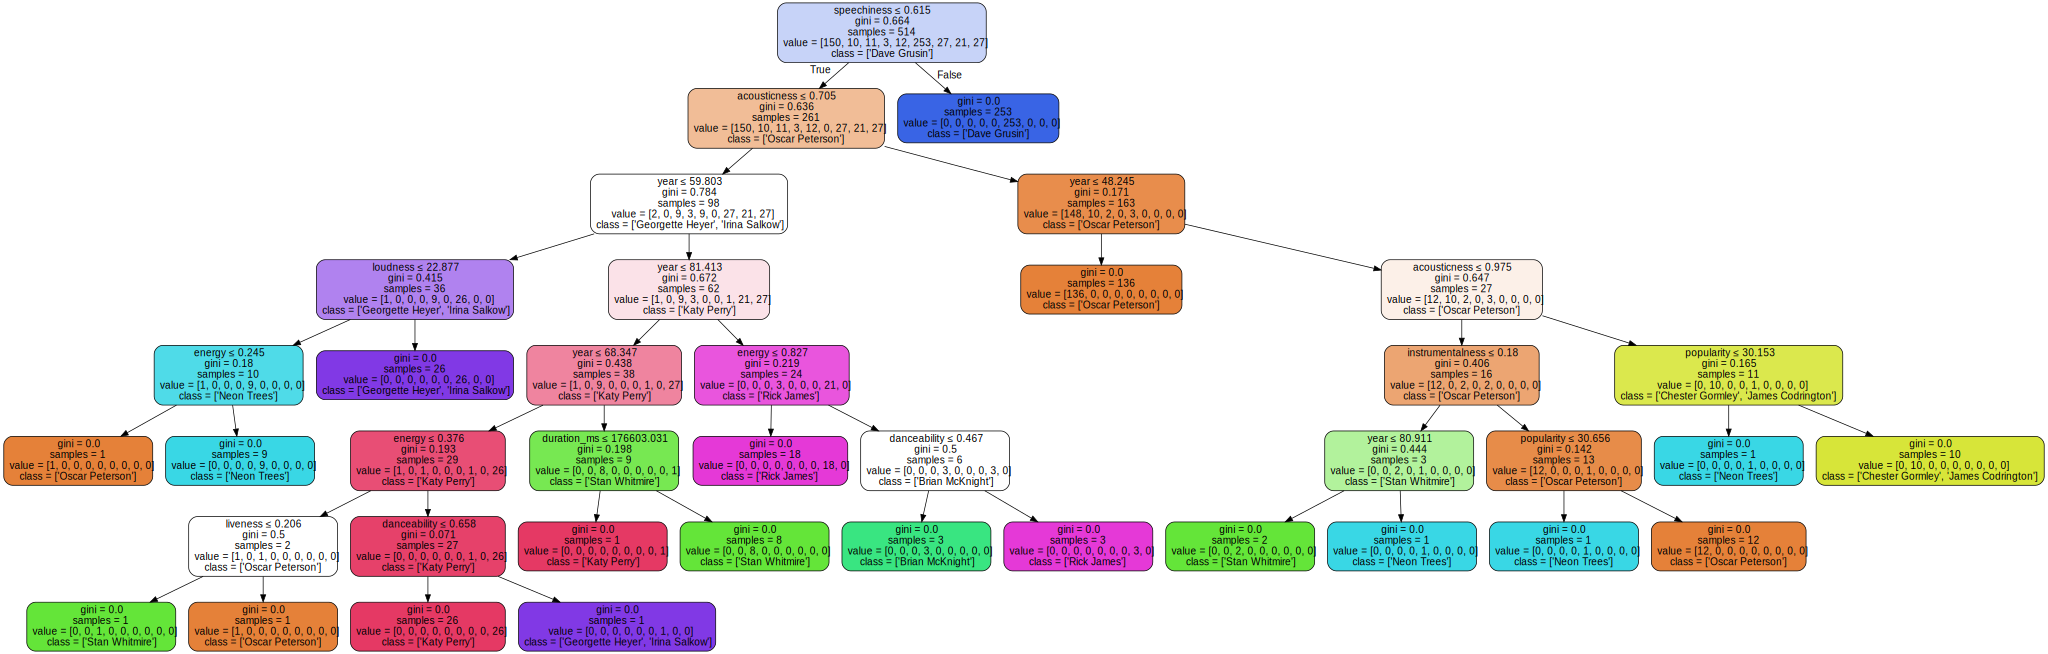

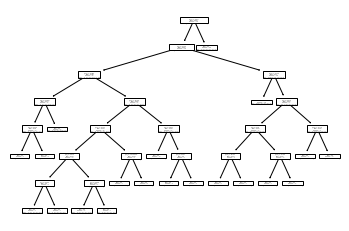

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import graphviz

X_train = tf_dataset[0]
Y_train = tf_dataset[1]
X_test = tf_dataset[2]
Y_test = tf_dataset[3]

clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
print("Confusion Matrix: ", confusion_matrix(Y_test, y_pred))
acc = accuracy_score(Y_test, y_pred)*100
print("Accuracy score: ", acc)
print("Classification Report: \n", classification_report(Y_test, y_pred))

tree.plot_tree(clf)
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=row_swaps[:15],  
                      class_names=Artists,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


In [ ]:
import numpy as np
import pandas as pd
import copy
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

class Algorithm:
    def Train():
        pass

    def Test(testing_data, testing_classes) -> float:
        return 0.0
    
    def Classify(datum) -> list:
        return []

class DecisionTreeWrapper(Algorithm):
    self.TrainingData = []
    self.TrainingClasses = []
    self.Classes = []
    self.DecisionTree = None
    self.Accuracy = 0.0

    def __init__(training_data, training_labels, classes):
        self.TrainingData = copy.deepcopy(training_data)
        self.TrainingLabels = training_labels
        self.Classes = classes
        self.DecisionTree = DecisionTreeClassifier()

    def Train():
        self.DecisionTree.fit(self.TrainingData, self.TrainingClasses)
    
    def Test(testing_data, testing_classes):
        Predictions = self.DecisionTree.predict()
    
    def Classify(class_data):
        return self.DecisionTree.predict([class_data])[0]


class EnsembleClassifier:
    self.Algorithms = []
    self.Weights = []
    self.TrainingSet = []

    def __init__(training_dataset):
        pass